# Escaping particles

Sometimes we are not interested in particles that get too far from the central body.  Here we will define a radius beyond which we remove particles from the simulation.  Let's set up an artificial situation with 2 planets, and the inner one simply moves radially outward with $v > v_{escape}$.

In [1]:
import rebound
import numpy as np
def setupSimulation():
    rebound.reset()
    rebound.integrator = "ias15" # IAS15 is the default integrator, so we don't need this line
    rebound.add(m=1., ID=0)
    rebound.add(m=1e-3,x=1.,vx=2., ID=1)
    rebound.add(m=1e-3,a=1.25,anom=np.pi/2, ID=2)
    rebound.move_to_com()

We have assigned each particle an ID for later reference (see [IDs.ipynb](IDs.ipynb) for more information).

In [2]:
setupSimulation()
rebound.status()

---------------------------------
Rebound version:     	1.1.0
Build on:            	b'Jul  8 2015 17:19:30'
Number of particles: 	3
Simulation time:     	0.000000
---------------------------------
<rebound.Particle object, ID=0 m=1.0 x=-0.0009990009990009992 y=-0.0012475049900199603 z=0.0 vx=-0.0011044678947844577 vy=-5.47131839717181e-20 vz=0.0>
<rebound.Particle object, ID=1 m=0.001 x=0.999000999000999 y=-0.0012475049900199603 z=0.0 vx=1.9988955321052155 vy=-5.47131839717181e-20 vz=0.0>
<rebound.Particle object, ID=2 m=0.001 x=7.654467337747661e-17 y=1.24875249500998 z=0.0 vx=-0.894427637320758 vy=5.4767897155689803e-17 vz=0.0>
---------------------------------


We see that the IDs (first field displayed for each particle) are in ascending order starting from 0.  Now let's run a simulation for 20 years (in default units where $G=1$ of AU, yr/2$\pi$, and $M_\odot$, see [Units.ipynb](Units.ipynb) for how to change units), and set up a 50 AU sphere beyond which we remove particles from the simulation.  We can do this by passing a `maxR` value to `rebound.integrate`.  If a particle's distance (from the origin of whatever inertial reference frame chosen) exceeds `maxR`, the particle is removed from the simulation.  It's probably therefore important to have moved to the center of momentum frame in `setupSimulation()` so that our system doesn't slowly drift out of our sphere.

If we simply call `rebound.integrate(20.*2.*np.pi, maxR=50.)`, the program will crash due to the unhandled exception when the particle escapes.  This setup allows us to instead catch the exception and deal with it in a customized way.  Let's try removing escaping particles from the simulation with the `rebound.remove_particle` function.  `rebound.remove_particle` takes the index in the `particles` array that you want to remove.  This is stored in the `index` member of the `ParticleEscaping` exception whenever a particle escapes:

In [3]:
setupSimulation() # Resets everything
Noutputs = 1000
times = np.linspace(0,20.*2.*np.pi,Noutputs)
xs = np.zeros((3,Noutputs))
ys = np.zeros((3,Noutputs))
for i,time in enumerate(times):
    try:
        rebound.integrate(time,maxR=50.)  
    except rebound.ParticleEscaping as error:
        print(error)
        rebound.remove_particle(error.index)
    for j in range(rebound.N):
        xs[j,i] = rebound.particles[j].x
        ys[j,i] = rebound.particles[j].y
    

At least one particle's distance > maxR at time 33.526518 (index = 1).


Let's check that the particle 1 was correctly removed from the simulation:

In [4]:
print("Number of particles remaining = {0}".format(rebound.N))
print("ID of rebound.particles[1] = {0}".format(rebound.particles[1].ID))

Number of particles remaining = 2
ID of rebound.particles[1] = 2


So this worked as expected.  We went down to 2 particles, and `particles[1]` (which had `ID = 1` before) has evidently been replaced with `particles[2]`).  By default, `rebound.remove_particles` preserves the ordering in the `particles` array (see [IDs.ipynb](IDs.ipynb) for more info).  Now let's plot what we got:

(-2, 10)

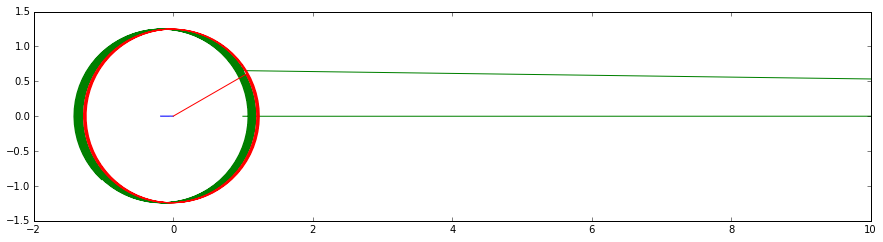

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=(15,5))
for i in range(3):
    ax.plot(xs[i,:], ys[i,:])
ax.set_aspect('equal')
ax.set_xlim([-2,10])

Uh oh.  The problem here is that we kept updating `xs[1]` with `particles[1].x` after `particle[1]` was removed.  This means that following the removal, `xs[1]` all of a sudden started getting populated by the values for the particle with `ID=2`.  This is why the radial green trajectory (horizontal line along the $x$ axis) all of a sudden jumps onto the roughly circular orbit corresponding to the outer particle with `ID=2` (originally red).  One way to fix these problems is:

At least one particle's distance > maxR at time 33.526518 (index = 1).


(-2, 10)

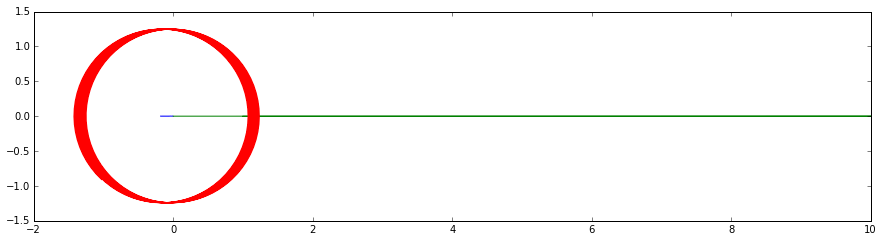

In [6]:
setupSimulation() # Resets everything
Noutputs = 1000
times = np.linspace(0,20.*2.*np.pi,Noutputs)
xs = np.zeros((3,Noutputs))
ys = np.zeros((3,Noutputs))
for i,time in enumerate(times):
    try:
        rebound.integrate(time,maxR=50.)   
    except rebound.ParticleEscaping as error:
        print(error)
        rebound.remove_particle(error.index)
    for j in range(rebound.N):
        xs[rebound.particles[j].ID,i] = rebound.particles[j].x
        ys[rebound.particles[j].ID,i] = rebound.particles[j].y
    
fig,ax = plt.subplots(figsize=(15,5))
for i in range(3):
    ax.plot(xs[i,:], ys[i,:])
ax.set_aspect('equal')
ax.set_xlim([-2,10])

Much better!  Since at the beginning of the integration the IDs match up with the corresponding indices in the `xs` and `ys` arrays, we solved problem by using the IDs as indices throughout the simulation.

As an aside, the horizontal drift of the circular orbit is a real effect:  in the center of mass frame, if the Jupiter-mass planet is drifting right at some speed, the Sun must be moving at a speed lower by a factor of approximately 1000 (their mass ratio) in the opposite direction, so the Sun-particle2 system slowly drifts left.  If we integrated long enough, this would mean all our particles would eventually leave our box.  

If we wanted to make sure things stayed in the box, we could additionally move to new center of mass frame after each removal of a particle, but this would introduce unphysical jumps in the remaining particles' time series, since their coordinates are measured between different inertial frames.  Of course, whether this matters depends on the application!